In [6]:
# -------- Imports --------
import sys
import os
import numpy as np
import scipy.sparse as sp
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from _utility import *

# -- Qiskit imports --
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
from qiskit.primitives import StatevectorEstimator

np.random.seed(0)


In [7]:
# -------- Parameters --------
# -- Grid parameters --
Nx, Ny, Nz = 4, 4, 4
dx, dy, dz = 1.0, 1.0, 1.0

# Calculate staggered grid sizes for 3D elastic
N_main = Nx * Ny * Nz
N_vx = (Nx-1) * Ny * Nz
N_vy = Nx * (Ny-1) * Nz
N_vz = Nx * Ny * (Nz-1)
N_sxy = (Nx-1) * (Ny-1) * Nz
N_sxz = (Nx-1) * Ny * (Nz-1)
N_syz = Nx * (Ny-1) * (Nz-1)
N_vel = N_vx + N_vy + N_vz
N_stress = 3*N_main + N_sxy + N_sxz + N_syz
psi_len = N_vel + N_stress  # Total state vector size for 3D elastic

# -- Simulation parameters --
t = 5.0

# -- Subspace projector --
mask = np.random.choice([0, 1], size=psi_len, p=[0.9, 0.1])


In [8]:
# Important: The following implementation of the material parameters is not scalable. This code is only for demonstration purposes and assumes oracle access. 
# In a real-world scenario, the material parameters and the Hamiltonian need to be sparsly constructed on the QC itself.
# Furthermore, this code uses direct matrix exponentiation, which is inefficient for large matrices. Other integration methods should be used (e.g. Trotter-Suzuki, Qubitization).

# -- Material properties (Oracle Access) -- 
# P-wave and S-wave velocities
c_p = 3.0  # P-wave velocity
c_s = 1.5  # S-wave velocity
rho0 = 2.0  # Density

# Density model (3D)
rho_model = rho0 * np.ones((Nz, Ny, Nx))

# Compliance matrix (from velocities)
S_matrix = create_compliance_matrix_from_velocities(c_p, c_s, rho0)

# -------- Simulation (3D Elastic) (Oracle Access) --------
(H, A, _, B_sqrt, B_inv, _) = FD_solver_3D_elastic_quantum(Nx, Ny, Nz, dx, dy, dz, rho_model, S_matrix)

# Extract the real part of H for Pauli conversion
# H = 1j * H_real, so H_real = -1j * H
# Since H is purely imaginary, we extract the imaginary part and negate it
H_real = -1j * H
H_pauli = SparsePauliOp.from_operator(Operator(H_real.toarray())) # Expensive conversion
print("Hamiltonian shape: ", H.shape)
print("Hamiltonian NNZ-Ratio: ", H.nnz/H.shape[0]**2)
print("Pauli Terms (inefficient representation): ", len(H_pauli))

# Number of grid points
N = Nx*Ny*Nz
print("Number of grid points: ", N)

# Number of qubits
n = (H.shape[0]-1).bit_length()
print("Number of qubits (for wave field): ", n)


Hamiltonian shape:  (512, 512)
Hamiltonian NNZ-Ratio:  0.00457763671875
Pauli Terms (inefficient representation):  20720
Number of grid points:  64
Number of qubits (for wave field):  9


In [ ]:
# -- Initial Conditions (3D Elastic) --
# State vector: [v_x, v_y, v_z, σ_xx, σ_yy, σ_zz, σ_xy, σ_xz, σ_yz]

f0 = 2.0            # Central frequency of the Ricker wavelet
x0, y0, z0 = 0.0, 0.0, 0.0   # Wavelet center

# Create 3D meshgrid for v_x grid (Nx-1, Ny, Nz)
# v_x is on staggered grid in x-direction
x_vx = np.linspace(-1 + dx/2, 1 - dx/2, Nx-1)
y_vx = np.linspace(-1, 1, Ny)
z_vx = np.linspace(-1, 1, Nz)
X_vx, Y_vx, Z_vx = np.meshgrid(x_vx, y_vx, z_vx, indexing='ij')

# Initialize velocity components (all zeros initially)
v0x = np.zeros((Nx-1, Ny, Nz))
v0y = np.zeros((Nx, Ny-1, Nz))
v0z = np.zeros((Nx, Ny, Nz-1))

# Initialize stress components (all zeros initially)
sigma_xx = np.zeros((Nx, Ny, Nz))
sigma_yy = np.zeros((Nx, Ny, Nz))
sigma_zz = np.zeros((Nx, Ny, Nz))
sigma_xy = np.zeros((Nx-1, Ny-1, Nz))
sigma_xz = np.zeros((Nx-1, Ny, Nz-1))
sigma_yz = np.zeros((Nx, Ny-1, Nz-1))

# Add a Ricker wavelet source to v_x component similarly to the acoustic case
# Ricker function takes (f, x, y, z, x0, y0, z0) and returns a scalar or array
ricker_vx = Ricker(f0, X_vx, Y_vx, Z_vx, x0, y0, z0)
v0x = np.round(ricker_vx, 20)

# Stack the initial conditions in the correct order:
# [v_x, v_y, v_z, σ_xx, σ_yy, σ_zz, σ_xy, σ_xz, σ_yz]
phi_0 = np.concatenate([
    v0x.flatten(),      # v_x: (Nx-1)*Ny*Nz
    v0y.flatten(),      # v_y: Nx*(Ny-1)*Nz
    v0z.flatten(),      # v_z: Nx*Ny*(Nz-1)
    sigma_xx.flatten(), # σ_xx: Nx*Ny*Nz
    sigma_yy.flatten(), # σ_yy: Nx*Ny*Nz
    sigma_zz.flatten(), # σ_zz: Nx*Ny*Nz
    sigma_xy.flatten(), # σ_xy: (Nx-1)*(Ny-1)*Nz
    sigma_xz.flatten(), # σ_xz: (Nx-1)*Ny*(Nz-1)
    sigma_yz.flatten()  # σ_yz: Nx*(Ny-1)*(Nz-1)
])

# Pad the initial conditions with zeros to match Hamiltonian size (power of 2)
phi_0 = np.concatenate([phi_0, np.zeros(H.shape[0] - psi_len)])

# Normalize the initial state and transform it to the energy basis
psi_0 = B_sqrt @ phi_0
norm = np.linalg.norm(psi_0)
psi_0 /= norm

# Number of non-zero initial state values
psi_0_nnz = np.sum(psi_0 != 0)
print('Initial state NNZ-Ratio:', psi_0_nnz/psi_len)

# Pad the mask with zeros
mask = np.concatenate([mask, np.zeros(H.shape[0]-psi_len)])


Initial state NNZ-Ratio: 0.04504504504504504


Observable Pauli terms:  2


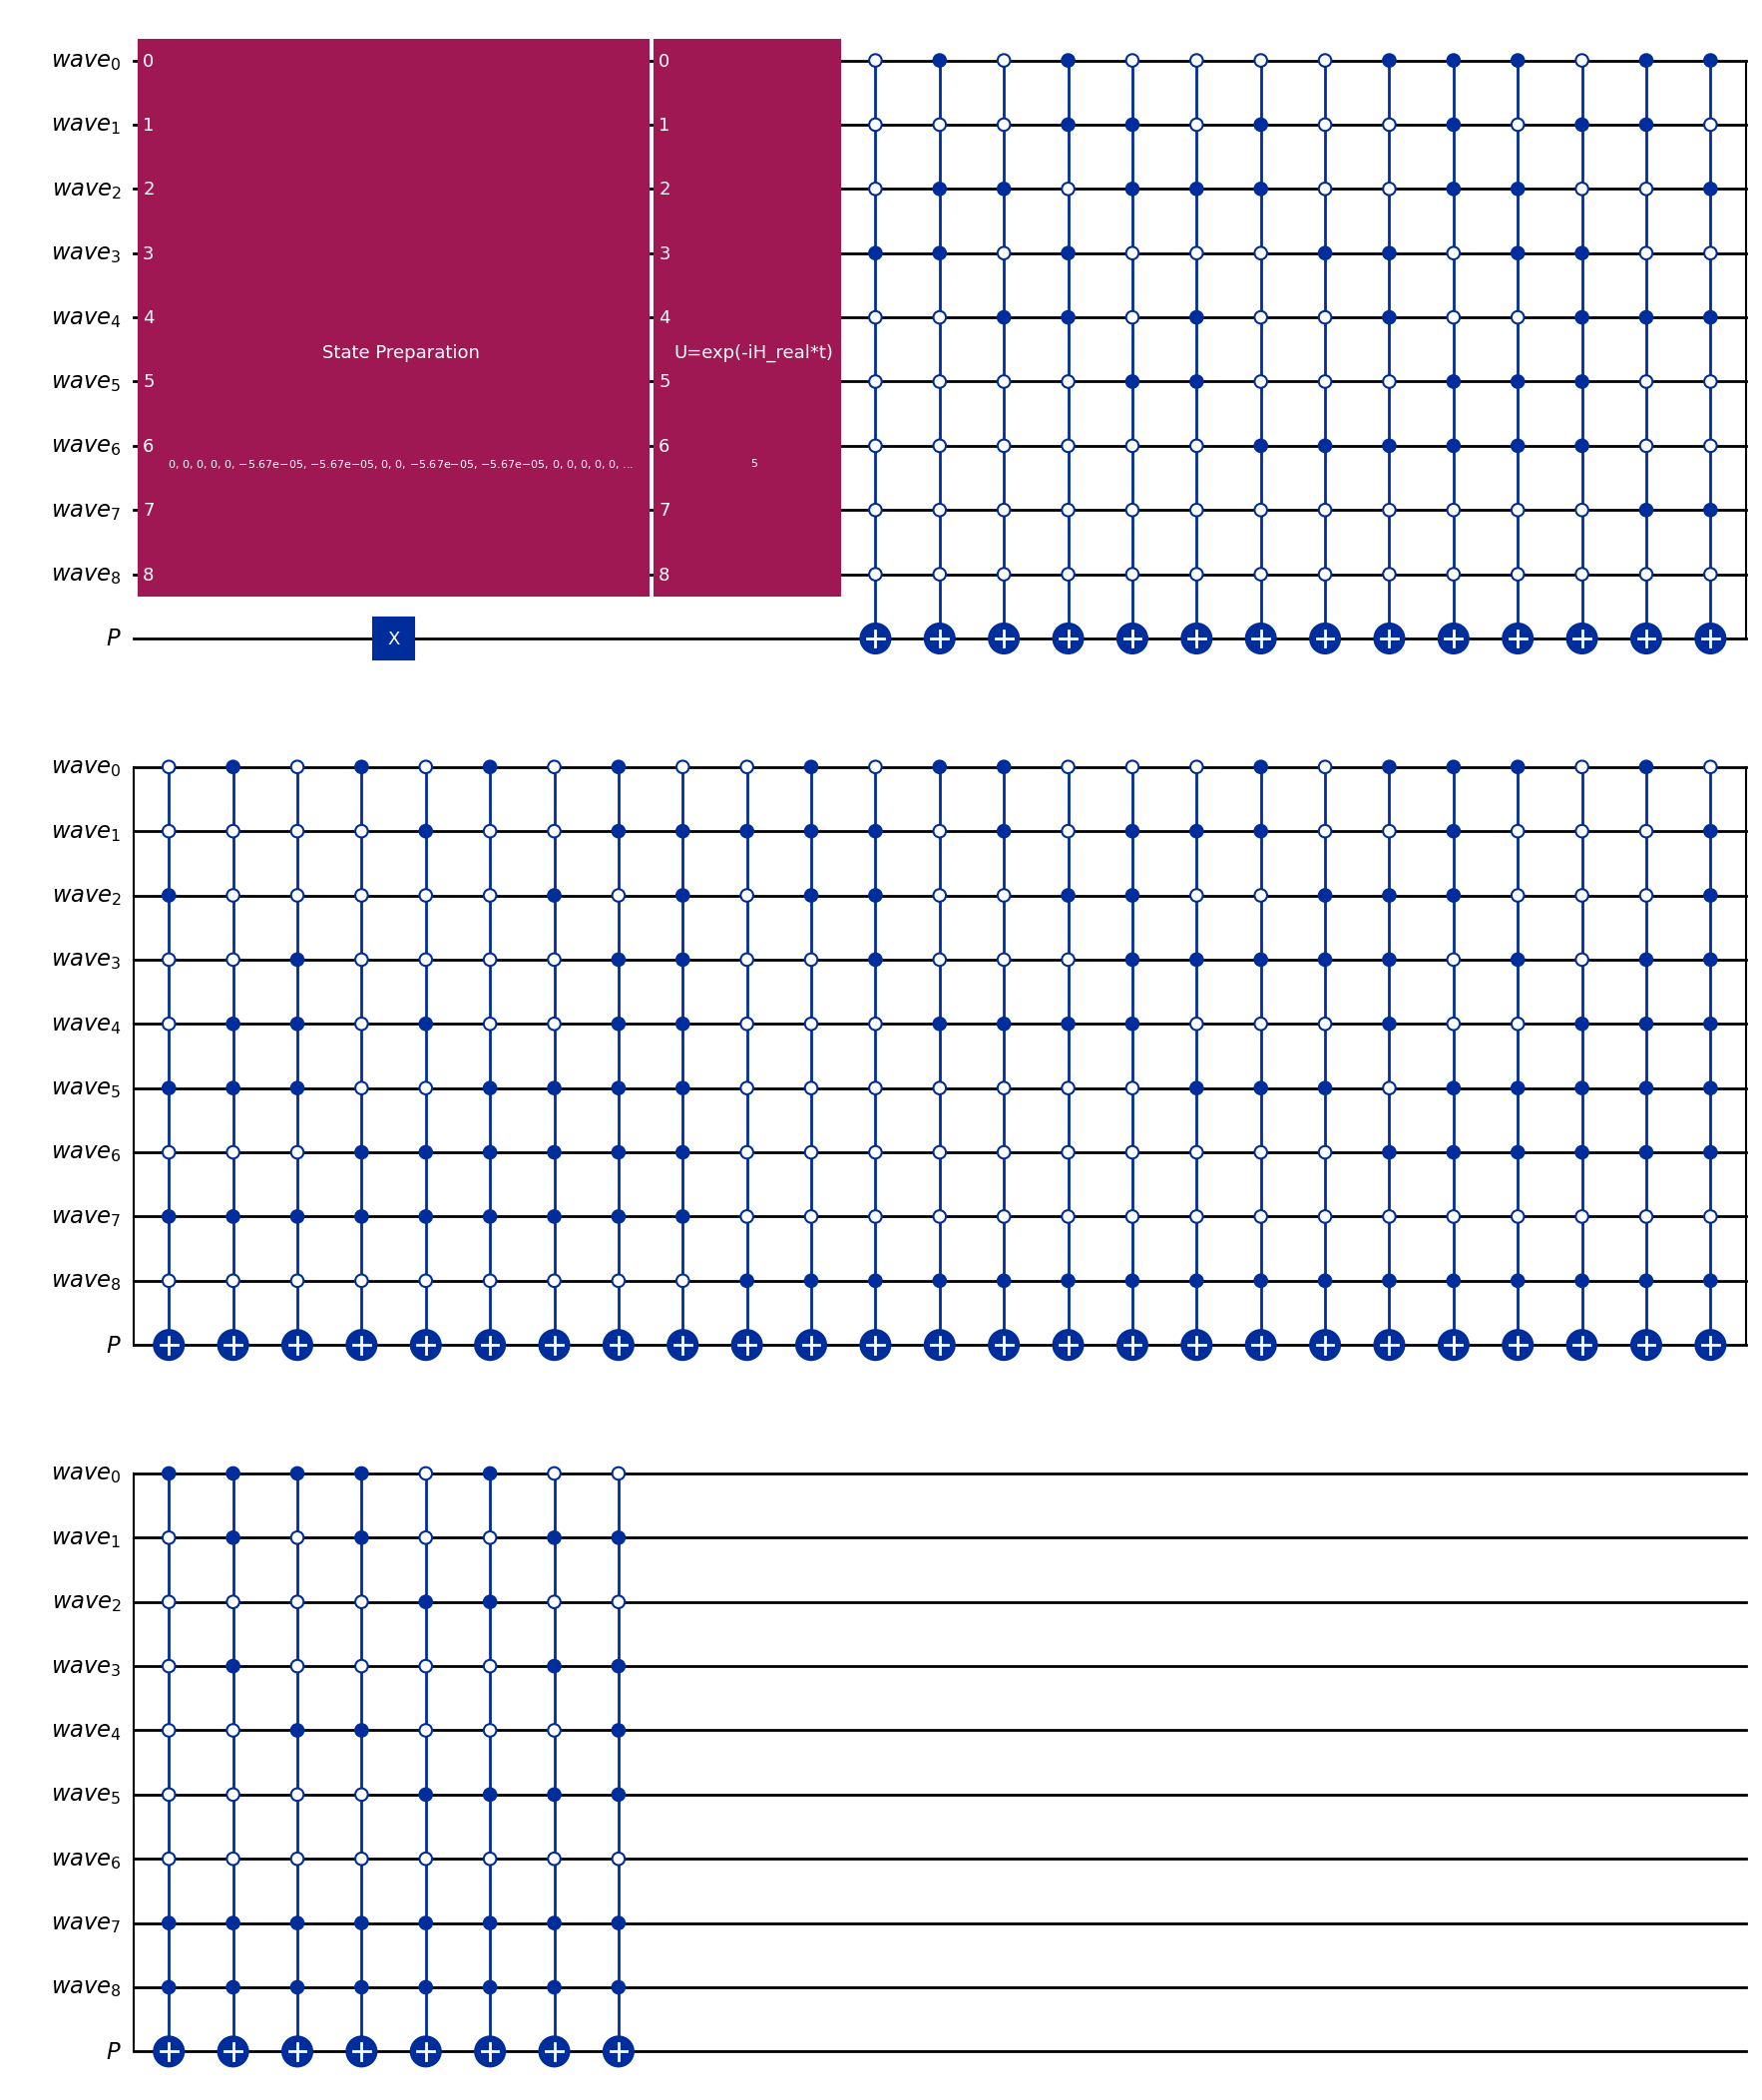

In [10]:
# -------- Quantum Circuit --------
# -- Time-evolution Synthesis --
# Note: H = 1j * H_real where H_real is real and symmetric (hence Hermitian)
# The classical evolution is: |ψ(t)⟩ = exp(-1j * H * t) |ψ(0)⟩ = exp(H_real * t) |ψ(0)⟩
# PauliEvolutionGate implements exp(-i * H_pauli * t) where H_pauli must be Hermitian with real coefficients
# Since H_pauli = H_real, we get exp(-i * H_real * t) = cos(H_real * t) - i*sin(H_real * t)
# For small times or when H_real has small eigenvalues, the real part approximates exp(H_real * t)
# We use H_real with time t to get unitary evolution exp(-i * H_real * t)
synthesis = MatrixExponential()
evo = PauliEvolutionGate(H_pauli, time=t, synthesis=synthesis, label='U=exp(-iH_real*t)')

# -- Quantum Simulation --
# Define the quantum registers
reg_wave = QuantumRegister(n, 'wave')
reg_P = QuantumRegister(1, 'P')

# Initialize the quantum circuit
qc = QuantumCircuit(reg_wave, reg_P)
qc.prepare_state(psi_0, reg_wave)

# Apply the time-evolution operator
qc.append(evo, reg_wave)

# Apply unitary "projection" transform (Can often be combined into fewer MCX gates)
qc.x(reg_P)
for d in np.nonzero(mask)[0]:
    qc.mcx(reg_wave, target_qubit=reg_P, ctrl_state=int(d))

# Define observable
O1 = Pauli('I'*(n+1))
O2 = Pauli('Z'+'I'*n)
observable = SparsePauliOp([O1, O2], [0.5, 0.5])
print("Observable Pauli terms: ", len(observable))

# Draw the circuit
qc.draw('mpl')


In [11]:
# -------- Simulation --------
# Simulate the quantum circuit
estimator = StatevectorEstimator()
job = estimator.run([(qc, observable)], precision=1e-8)
result = job.result()
print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")


 > Expectation value: 0.09408245546640627
 > Metadata: {'target_precision': 1e-08, 'circuit_metadata': {}}


In [12]:
# Compute the energy loss (post-processing)
E = result[0].data.evs
EN_QC = (1/2) * E * norm**2 * (dx * dy * dz)
print('Subspace Energy Estimate (quantum):', EN_QC.round(10))


Subspace Energy Estimate (quantum): 2.4708e-06


In [14]:
# Time Integration (Has classical integration errors (DOP853))
# Note: Use normalized initial state for fair comparison with quantum
phi_0_normalized = phi_0 / norm  # Normalize using the same norm as quantum
phi_t = solve_ivp(lambda t, phi: (B_inv @ A @ phi), (0, t), phi_0_normalized, t_eval=(0,t), method='DOP853').y.T[-1] 

# Transform to energy basis (same as quantum case)
psi_t_classical = B_sqrt @ phi_t

# Calculate subspace energy using the same normalization as quantum
# The mask selects which states to measure, then we compute the probability
masked_state = np.diag(mask) @ psi_t_classical
# Probability of being in the masked subspace
prob_in_subspace = np.linalg.norm(masked_state)**2 / np.linalg.norm(psi_t_classical)**2
EN_CL = (1/2) * prob_in_subspace * norm**2 * (dx * dy * dz)
print('Subspace Energy Estimate (classical):', EN_CL.round(10))


Subspace Energy Estimate (classical): 3.8754e-06
